In [5]:
from TextNormalization.WithPytorch.dataloader import DataLoader

loader = DataLoader(10)
loader.parse_person_corpus('TextNormalization/Persons-1000/collection')
loader.parse_rdf_corpus('corpus_for_pakhomov_2/')

'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Абдулла Гюль.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Адам Осмаев.xml
'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Азим Исабеков.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Александр Глухов.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Александр Ломая.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Александр Медведько.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Анатолий Бибилов.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Андрей Аршавин.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Владимир Сергеевич Высоцкий.xml


'NoneType' object has no attribute 'text' corpus_for_pakhomov_2/Евгений Чичваркин.xml


In [2]:
from os.path import abspath

abspath('./')

'C:\\Users\\Sdernal\\Desktop\\Jackals'

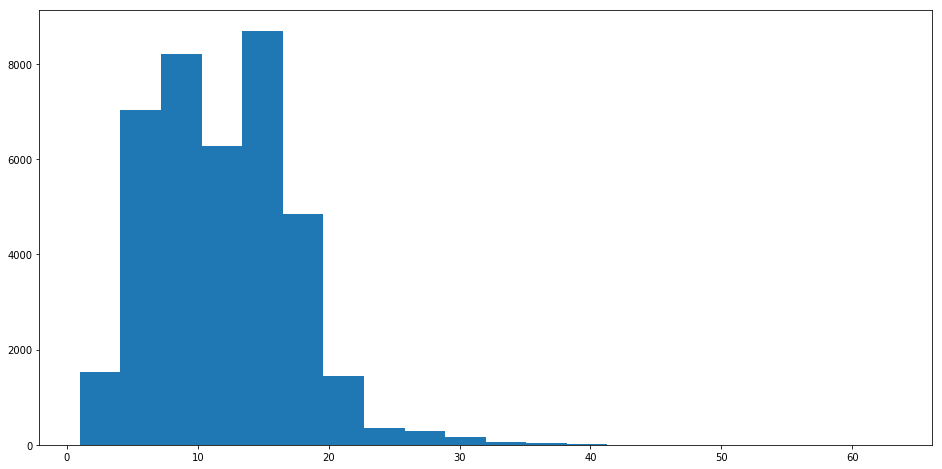

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
enteties_lengths = list(map(lambda x: x.length, loader.enties))
plt.figure(figsize=(16,8))
plt.hist(enteties_lengths, bins=20 )
plt.show()

In [35]:
from TextNormalization.WithPytorch.entriesprocessor import EntriesProcessor
ep = EntriesProcessor(20,40)
ep.process(loader.enties)

In [29]:
ep = EntriesProcessor()
ep.process(loader.enties)

In [1]:
import torch

In [10]:
a = torch.empty(1,*a).size()

In [36]:
len(ep.X_data)

37041

In [13]:
torch.ones(1,1,10)*2

tensor([[[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]]])